# Contents
- Electrons
  - Rewrite and plot previously determined electron functions
- Synchrotron 
  - Rewrite rate synchrotron and synchrotron spectrum 
  - Plot them 
  - Attempt at rewriting class didn't work.. Leave for now
- Comparison of Secondary and Primary Electron Populations
- COMA Data
  - Plot the PRimary population on top
  - Plot a simple power law without a fit
  

In [1]:
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates.sky_coordinate import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from astropy.wcs import WCS
from ClusterModel import model
from ClusterModel import model_modpar
from ClusterModel import model_tools

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
clust = model.Cluster(name='Coma', 
                      redshift=0.023, M500=7e14*u.Msun, 
                      cosmology=cosmo, silent=False, 
                      output_dir='/home/astrogamma/Project/Output/TestClusterModel')

                      ___   __    ___   __   __                      
                     / __) / _\  / __) /  \ (  )                     
                    ( (__ /    \( (_ \(  O )/ (_/\                   
                     \___)\_/\_/ \___/ \__/ \____/                   
   Cluster Atmosphere modeling for Gamma-ray Observations Libraries  
---------------------------------------------------------------------
                                                                     
Setting gNFW Planck coll. (2013) UPP.


# Models for Protons and Thermal Component

In [3]:
#----- Some parameters that can be set at when defining the cluster
clust.coord = SkyCoord("194.953d  27.9806d", frame="icrs", unit="deg")

#----- Define the relevant ICM model (available models are defined in model_modpar.py)

# Density profile of the target thermal gas
clust.density_gas_model = {'name':'beta', 'n_0':3e-3*u.cm**-3, 'beta':2.0/3, 'r_c':290*u.kpc}

# Pressure profile of the target thermal gas
clust.pressure_gas_model = {'name':'GNFW', 'P_0':2.2e-2*u.keV/u.cm**3, 'c500':2.9, 'a':1.8, 'b':3.1, 'c':0.0}

# Set the cosmic ray density profile to the same shape as the thermal gas density
clust.set_density_crp_isodens_scal_param()

# Cosmic ray proton spectrum
clust.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.3}

# Cosmic ray proton normalization
clust.X_cr_E = {'X':0.01, 'R_norm':clust.R500} # X is the CRp/thermal energy ratio, normalized within R_norm

Setting coord value
Setting density_gas_model value
Fixing: R500
Setting pressure_gas_model value
Fixing: R500
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value


# Set up a Model for Electrons

In [4]:
#Set some random stolen models for the primary electrons
clust.spectrum_cre1_model = {'name':  'PowerLaw', 'Index':2.3}
                             #'ExponentialCutoffPowerLaw','Index':3.3, 'CutoffEnergy':1e7*u.keV}
                           
                        
## You can try building a model incorporating the energy losses from sync and IC!


## For density you can just make the same as protons --> set it equal to the thermal gas 
clust.density_cre1_model = {'name': 'beta', 'n_0':3e-3*u.cm**-3, 'beta':2.0/3, 'r_c':290*u.kpc}

#pull out some random min and max energies
Eemin = clust.Epmin 
Eemax = clust.Epmax

Getting the minimal proton energy
Getting the maximal proton energy


## Some Generic Functions for Electrons

In [5]:
## Just use the avalialble generic functions

clust.density_cre1_model['n_0'] = 1.0 *u.adu

def get_normed_density_cre1_profile(cl = clust, rad = np.logspace(0,4,100)*u.kpc):
    
   # rad = model_tools.check_qarray(rad, unit = 'kpc')
    nr = cl._get_generic_profile(rad, cl.density_cre1_model)
    nr[rad > cl._R_truncation] *= 0 
    
    return rad, nr.to('adu')


def get_normed_spectrum_cre1(cl , en): 
    
    se = cl._get_generic_spectrum(en, cl.spectrum_cre1_model)
    se[en >Eemax] *= 0
    se[en <Eemin] *= 0
    
    return en, se*u.adu

## Radius and Energy Values

In [6]:
radius=np.logspace(0,4,100)*u.kpc
energy=np.logspace(-2,7,100)*u.GeV

### Try out the generic functions now

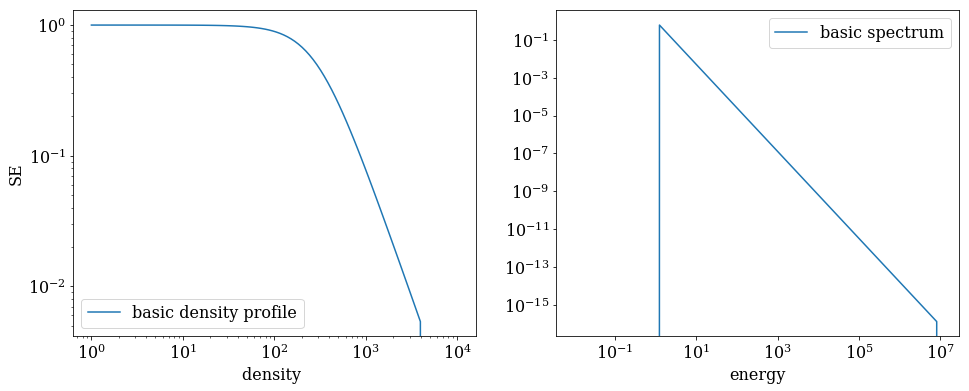

In [7]:
# The simplest plots: density profile and spectrum
plt.figure(figsize=(15,6))
plt.subplot(121)

a ,b = get_normed_density_cre1_profile(clust, radius)
plt.loglog(a,b, label='basic density profile')

plt.xlabel('density ')
plt.ylabel('SE')
plt.legend()


plt.subplot(122)
c, d = get_normed_spectrum_cre1(clust,energy)
plt.loglog(c,d,label = 'basic spectrum')
plt.xlabel('energy')
plt.legend()

## Norm: 
Set to 1 for now


In [8]:
A = 1/u.GeV/u.cm**3

## Below is how norm was obtained for protons :
from the thermal energy of gas ratio

In [10]:
X_cre_E = 0.001 ## This is made up!!


rnorm = clust.R500
rmin = 1.0*u.kpc
def norm_electrons(cl):
    
    #Thermal energy of gas
    raduth, uth = cl.get_thermal_energy_profile(rnorm)
    
    #Spatial volume
    rad = model_tools.sampling_array(rmin, rnorm, NptPd=clust._Npt_per_decade_integ, unit=True)
    rad, fd = get_normed_density_cre1_profile(cl, rad)
    volcre = model_tools.trapz_loglog(4*np.pi*rad**2 * fd.to_value('adu'),rad)
    
    #Energy in spectrum
    eng = model_tools.sampling_array(Eemin , Eemax, NptPd=clust._Npt_per_decade_integ, unit=True)
    eng, fe = get_normed_spectrum_cre1(cl, eng)
    Integ_eng = model_tools.trapz_loglog( eng* fe.to_value('adu'), eng)
    

    #final
    norm = X_cre_E* uth /volcre / Integ_eng
    return norm.to('GeV-1 cm-3')

Getting R500 value


## 2D Plot
This gives the differential spectrum

In [11]:


def cre1_2d(cl = clust, en= np.logspace(-2,7,100)*u.GeV, rd =np.logspace(0,4,100)*u.kpc):
    
    #norm
    #r = norm_electrons(clust)
    #norm_electrons(cl)
    #spatial
    rad, fd = get_normed_density_cre1_profile(cl, rd)
    fd2 = model_tools.replicate_array(fd.to_value('adu'), len(en), T = False )
    #energy
    eng, fe = get_normed_spectrum_cre1(cl, en)
    fe2 = model_tools.replicate_array(fe.to_value('adu'), len(rd), T = True )
    
    spectrum= A*fd2*fe2
     
    return spectrum.to('GeV-1 cm-3')




In [20]:
len(eng_try)

207

/home/astrogamma/.local/anaconda3/envs/cta/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


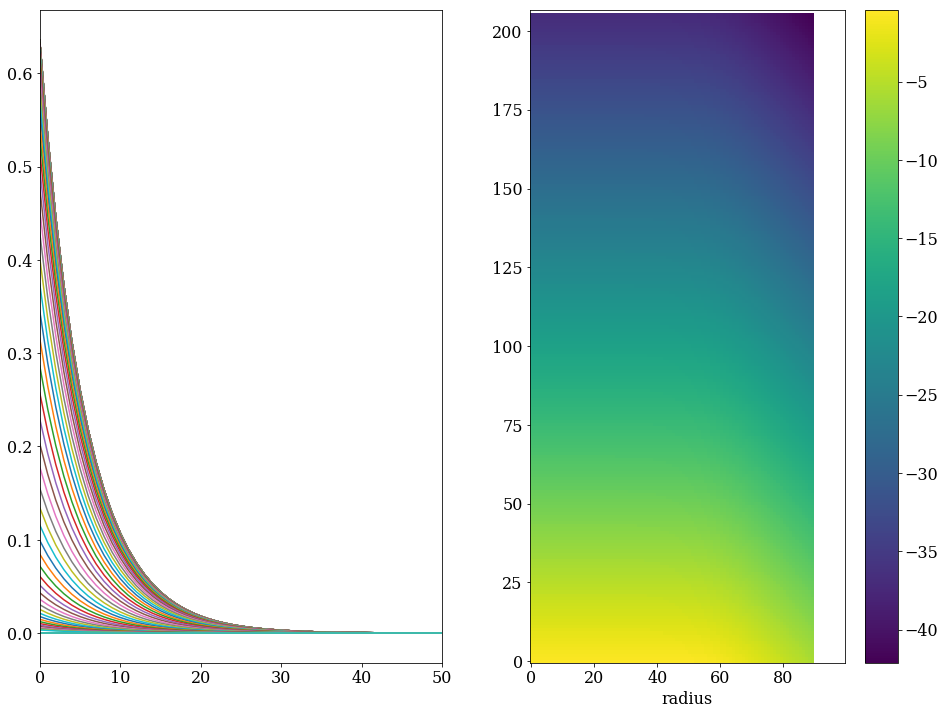

In [12]:
radius=np.logspace(0,4,100)*u.kpc
eng_try = model_tools.sampling_array(Eemin, Eemax, NptPd=clust._Npt_per_decade_integ, unit=True)
dndedv_try = cre1_2d(clust, eng_try,radius)

plt.figure(figsize = (15,12))
plt.subplot(122)
plt.imshow(np.log(dndedv_try.value), origin = 'lower')
plt.xlabel("radius")
plt.colorbar()

plt.subplot(121)
plt.plot(dndedv_try)
plt.xlim(0,50)
plt.show()

# Density Profile
Integrate over energies to obtain density profile


In [13]:
def density_cre1_profile(rad = np.logspace(0,4,100)*u.kpc, Emin = None, Emax = None):
    
    if Emin is None:
        Emin = (const.m_e*const.c**2).to('GeV')
    if Emax is None:
        Emax = clust._Epmax
    
    #Define energy range
    eng = model_tools.sampling_array(Emin, Emax,NptPd = clust._Npt_per_decade_integ, unit = True)
    
    #2D differntial spectrum
    dN_dEdV = cre1_2d(clust, eng, rad)
    
    #Integrate the diffferential spectrum 
    prof = (model_tools.trapz_loglog(dN_dEdV, eng, axis = 0)).to('cm-3')
    
    return rad, prof 

### Use it

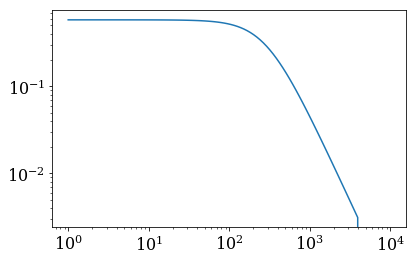

In [14]:
radius_prof, density_prof = density_cre1_profile()
plt.loglog(radius_prof, density_prof)
plt.show()

# SYNCHROTRON
 In Rémi's code:
 - A class has all the emission coming from electrons; the sync one uses the Aharonian et al paper's Appendix for physics equations and apprx AND takes the 2D differential spectra of the electron population 
 - A function "get rate synchotron" calls the class object and extracts the spectrum via also calling the B field and defining the # electrons for energy spectrum (Je) 
 - A function "get synchrotron spectrum" takes this and integrates it

## Without the class -- DOES NOT WORK -----------------------------------------------------------
- It doesn't work due to problems with array lengts I think


In [42]:
#rate sync
from scipy.special import cbrt


def Gtilde( x):
  
        cb = cbrt(x) # x**1/3
        gt1 = 1.808 * cb / np.sqrt(1 + 3.4 * cb ** 2.0)
        gt2 = 1 + 2.210 * cb ** 2.0 + 0.347 * cb ** 4.0
        gt3 = 1 + 1.353 * cb ** 2.0 + 0.217 * cb ** 4.0
        
        return gt1 * (gt2 / gt3) * np.exp(-x)
    


def synchrotron( Ephoton_input, radius, B=1.0*u.uG):
        
        NptEePd = 100
        #Electron energy
        Eemino = (const.m_e *const.c**2).to_value('GeV')
        Eemaxo = clust.Epmax
        Eemaxo = Eemaxo.to_value('GeV')
        Eeo = np.logspace(np.log10(Eemino), np.log10(Eemaxo), 100)
                          #int(NptEePd*(np.log10(Eemaxo/Eemino))))

        # Check input photons
        Ephoton = Ephoton_input.to('eV')
        if type(Ephoton) == float: Ephoton = np.array([Ephoton])
#Eemin = clust.Epmin 
#Eemax = clust.Epmax
      
        gamma = (Eeo/(const.m_e*const.c**2).to_value('GeV')) # 1D
        ampli = np.sqrt(3)/(8*np.pi**2)*(const.e.value*const.e.unit)**3/(const.eps0*const.m_e*const.c*const.hbar)

        #---------- Case of integrated quantities, no radius
        # Get the electron distribution
        Je = cre1_2d( clust, Eeo*u.GeV, radius).to_value('GeV-1 cm-3').T*u.GeV**-1
        #Je = Je*u.GeV**-1

        # Get the normalization function (1D: Ephot)
        func = ampli * B / Ephoton
        
        # Get the critical energy and energy ratio
        Ec = (3.0/2)*gamma**2*const.e.value*const.e.unit*B*const.hbar / (const.m_e) # 1D: Eelec
        EphotEc = Ephoton.to_value('GeV') / np.vstack(Ec.to_value('GeV')) # 2D: photon energy, electron energy

        # Compute integrand
        dNphot_dEdt = func * Gtilde(EphotEc)
        
        # Integrate over electron energy
        dNphot_dEdt = model_tools.trapz_loglog(np.vstack(Je.value)*Je.unit * dNphot_dEdt, Eeo*u.GeV, axis=0)

        # Get the output
        output = dNphot_dEdt.to('GeV-1 s-1')

        return output 
    
    
    
    

def rate_syncR(energy = np.logspace(-9,-2,100)*u.eV, radius = np.logspace(0,4,100)*u.kpc ):
    
   #Get Magnetic field
    radius, B = clust.get_magfield_profile(radius)
        
    rate = synchrotron( energy, radius, B).T
    
    return rate
#.to('GeV-1 cm-3 s-1')




# above section does not work ------------------------------------------------------------

### Use the ClusterEmission Class
Need to rewrite get rate synchrotron

In [38]:
from ClusterModel.ClusterTools import cluster_electron_emission as emi


def rate_sync(energy = np.logspace(-9,-2,100)*u.eV, radius = np.logspace(0,4,100)*u.kpc ):
    
    #Get Magnetic field
    radius, B = clust.get_magfield_profile(radius)
    
    #Define Je: 
    def Je2( rad, eng): return cre1_2d(clust, eng*u.GeV, rad*u.kpc).to_value('GeV-1 cm-3').T
    
    #Use the class
    model =  emi.ClusterElectronEmission (Je = Je2,Eemin=(const.m_e*const.c**2).to('GeV'), NptEePd=clust._Npt_per_decade_integ)
    rate = model.synchrotron( energy, radius_input = radius, B=B).T
    
    return rate.to('GeV-1 cm-3 s-1')

### Now use it

In [34]:
default = clust.get_rate_synchrotron()

dN_dEdVdt = rate_sync()


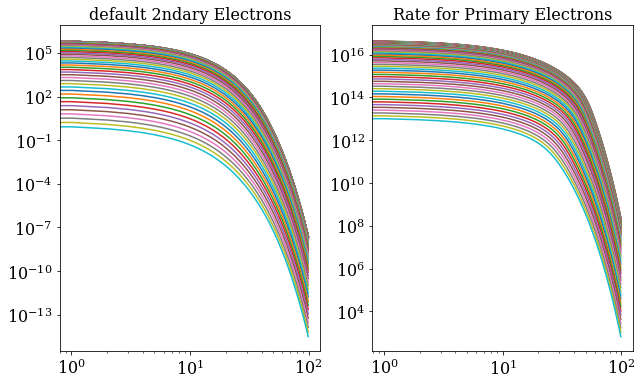

In [44]:
plt.figure(figsize=(15,6))
plt.subplot(131)
plt.loglog(default)
plt.title("default 2ndary Electrons")

plt.subplot(132)
plt.loglog(dN_dEdVdt)
plt.title("Rate for Primary Electrons")


#plt.subplot(133)
 #plt.loglog(noClass)
#plt.title("Rate for Primary Electrons")





plt.show()

## One plot for each radius:
- frequency on x axis
- on y: 


/home/astrogamma/.local/anaconda3/envs/cta/lib/python2.7/site-packages/astropy/units/quantity.py:640: RuntimeWarning: invalid value encountered in true_divide
  *arrays, **kwargs)


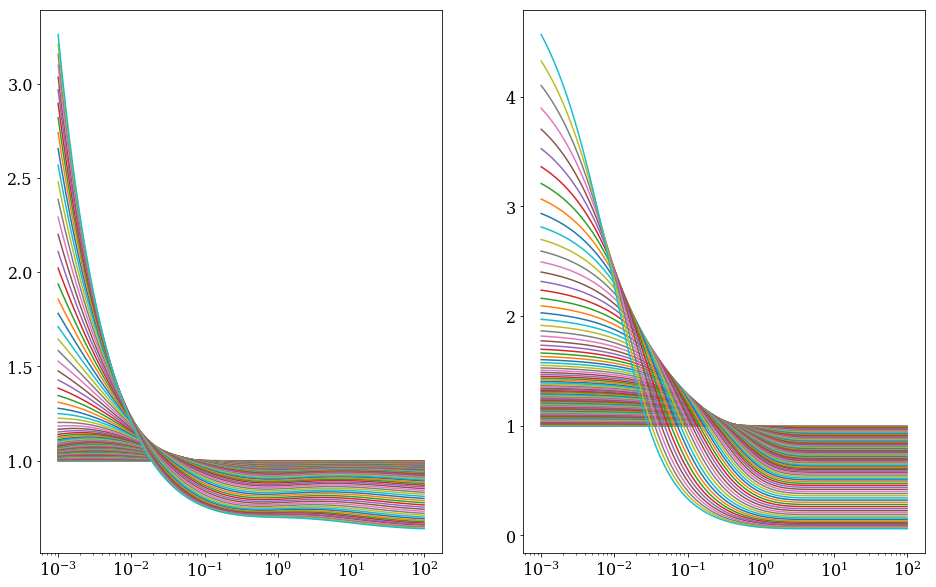

In [17]:
frequency = np.logspace(-3, 2, 100)*u.GHz
radius = np.logspace(0, 4, 100)*u.kpc

r = clust.get_rate_synchrotron(frequency*const.h, radius)
r2 = rate_sync(frequency*const.h, radius)

plt.figure( figsize=(15,10))
plt.subplot(121)
for i in range (len(radius)):
    plt.plot(frequency, (r[:,i]/r[:,0]) / np.mean(r[:,i]/r[:,0]))
plt.xscale('log')

plt.subplot(122)
for i in range(len(radius)):
    plt.plot(frequency, (r2[:,i]/r2[:,0]) / np.mean(r2[:,i]/r2[:,0]))
plt.xscale('log')

## Sync Spectrm Function

In [18]:
def sync_spectrum(freq = np.logspace(-3,2,100)*u.GHz, Rmin = None, Rmax = None):
    
    
    #Get energy
    energy = (const.h*freq).to('eV')
    
    #Determine boundaries
    if Rmin is None:
        Rmin = clust._Rmin
    if Rmax is None:
        Rmax = clust._R500
        
        
    #sample radius
    rad = model_tools.sampling_array(Rmin, Rmax, NptPd = clust._Npt_per_decade_integ, unit = True)
    #Use rate sync to get synchotron rate
    dNdEdVdt = rate_sync(energy, rad)
    #integrate spherically
    dNdEdt = model_tools.spherical_integration(dNdEdVdt, rad)
    
    #This gave us luminosity; now get flux 
    dNdEdSdt = dNdEdt / (4*np.pi * clust._D_lum**2)
    
    #Convert to Jy 
    return freq, (dNdEdSdt*energy**2 / freq).to('Jy')
    

Text(0.5,1,'new')

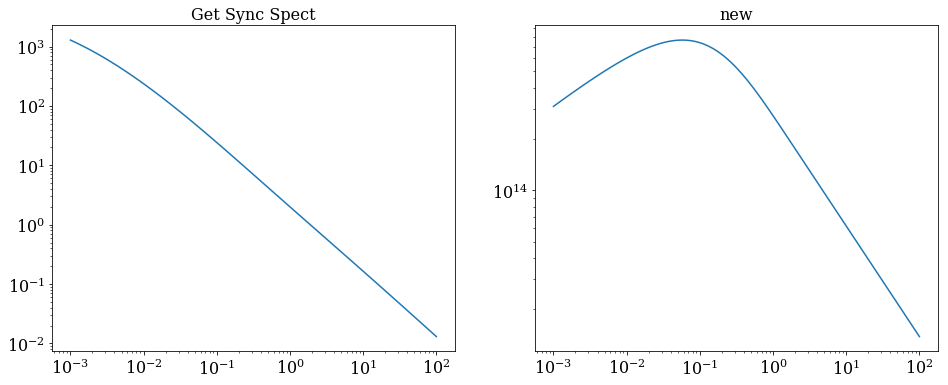

In [19]:
plt.figure(figsize = (15,6))
plt.subplot(121)
### Automatic function
frequency, readyspectrum = clust.get_synchrotron_spectrum()
plt.loglog(frequency,readyspectrum)
plt.title("Get Sync Spect")

#New one 
plt.subplot(122)
frequency, spectrum = sync_spectrum()
plt.loglog(frequency, spectrum)
plt.title("new")



## Compare secondary and Primary Populations
Density profiles

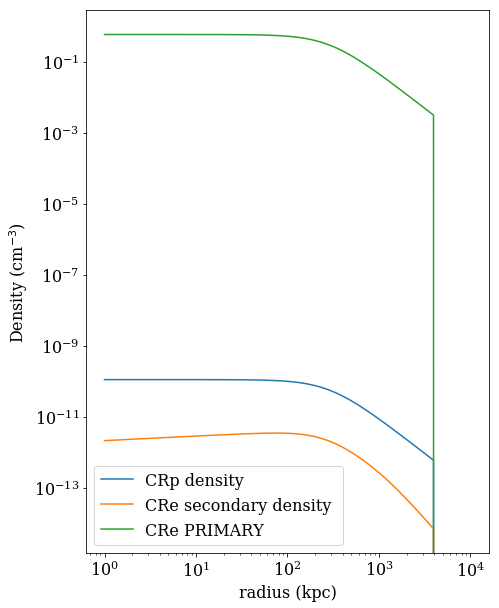

In [21]:
plt.figure(figsize = (15,10))
plt.subplot(121)
# Proton population
r, n_crp_r = clust.get_density_crp_profile()
plt.loglog(r, n_crp_r, label='CRp density ')

# Secondary Electron population

r, n_cre_r = clust.get_density_cre_profile()
plt.loglog(r, n_cre_r, label='CRe secondary density ')
plt.xlabel('radius (kpc)')
plt.ylabel('Density (cm$^{-3}$)')
plt.legend()

# Primary Electron Population

radius_prof, density_prof =  density_cre1_profile()
plt.loglog(radius_prof, density_prof,'-', label ='CRe PRIMARY')

plt.xlabel('radius (kpc)')
plt.ylabel('Density (cm$^{-3}$)')
plt.legend()
plt.show()

## Notes:
- Obviously CRe Primary needs to be normalized!
- CRe secondary has a peak, natural since it formes from protons (look at get CRe rate function)

# COMA DATA

In [22]:

clust.pressure_gas_model = {'name':'GNFW', 'P_0':2.2e-2*u.keV/u.cm**3,'a':1.8,'b':3.1,'c':0.0,'c500':2.9}

clust.density_gas_model = {'name':'beta', 'beta':2.0/3, 'r_c':290*u.kpc, 'n_0':3e-3*u.cm**-3}

# Radio total flux [Thierbach et al (2003)]:

dat_freq = np.array([30.9,43,73.8,151,326,408,430,608.5,1380,1400,2675,2700,4850])*u.MHz
dat_flux = np.array([49,51,17,7.2,3.81,2.0,2.55,1.2,0.53,0.64,0.11,0.07,0.03])*u.Jy
dat_err  = np.array([10,13,12,0.8,0.03,0.2,0.28,0.3,0.05,0.035,0.03,0.02,0.01])*u.Jy

Setting pressure_gas_model value
Fixing: R500
Setting density_gas_model value
Fixing: R500


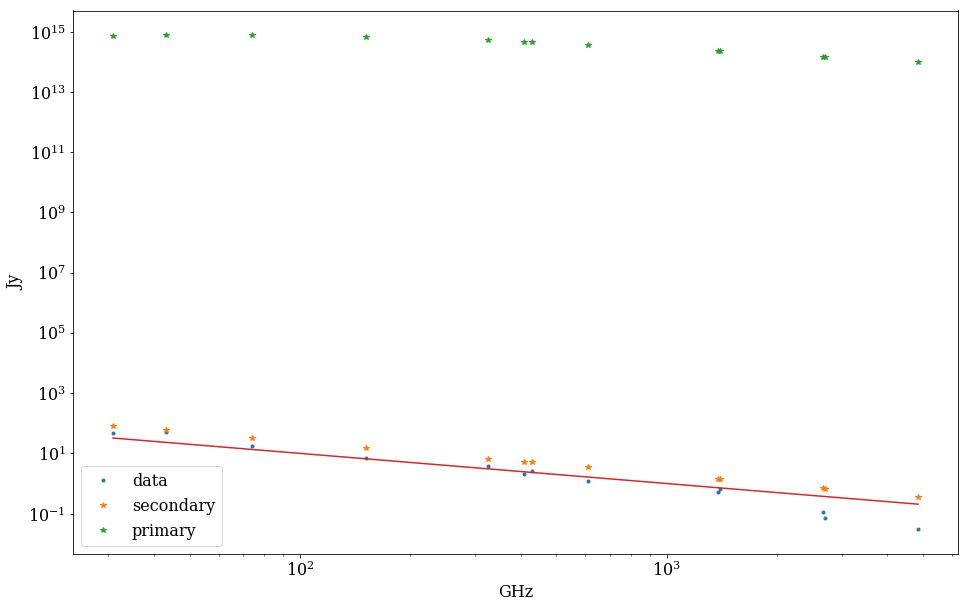

In [23]:

#Secondary
bid, s1 = clust.get_synchrotron_spectrum(dat_freq, Rmin=None, Rmax=None, type_integral='spherical', Rmin_los=None, 
                                   NR500_los=5.0, Cframe=False)
#Primary
dat_freq, spectrum = sync_spectrum(dat_freq)



def fitfunc(x):
    return 10**3*(x)**(-1)

trial = fitfunc(dat_freq)


plt.figure(figsize=(15,10))
##DATA
plt.loglog(dat_freq,dat_flux,".", label = "data")
#SECONDARY
plt.loglog(dat_freq, s1, "*", label = "secondary")
#PRIMARY
plt.loglog(dat_freq, spectrum, "*", label = "primary")

plt.loglog(dat_freq, trial)


plt.xlabel(frequency.unit)
plt.ylabel((s1).unit)
plt.legend()
plt.show()
